In [17]:
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import exactJWT
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
import networkx as nx

from quimb.tensor.tensor_core import tags_to_oset as tto

In [24]:
tags = ('S0,0',)
layer = 'KET'
tto((tags, layer))

oset([('S0,0',), 'KET'])

In [19]:
reload(beeky)
psi = beeky.QubitEncodeVector.rand(3,3)
# psi.setup_bmps_contraction_()
norm, bra, ket = psi.make_norm(return_all=True)
norm.rotate_face_qubits(layer_tag='BRA').graph_layers()


KeyError: 'Q'

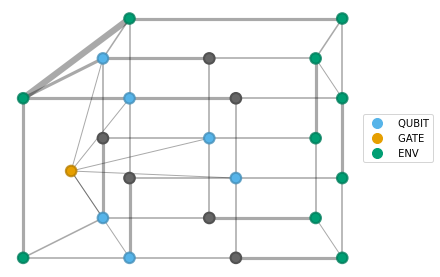

In [87]:
reload(beeky)
# SimHam = beeky.SpinlessSimHam(3,3)
# where_gate = (4,7,10)
# which_mpo = mpoham.get_term_at(*where_gate)

# which_gate = SimHam.get_term_at(*where_gate)

# psi = beeky.QubitEncodeVector.rand(3,3)
# psi.setup_bmps_contraction_()
# norm, bra, ket = psi.make_norm(return_all=True)

# plaq_info = ((2,2), (3,2))
# plaq_envs = norm.compute_plaquette_environments(x_bsz=3, y_bsz=2, first_contract='rows', layer_tags=('BRA','KET'))

# plaq_tags = psi.plaquette_at(xy=plaq_info[0], bsz=plaq_info[1], get='tags')
# env = plaq_envs[plaq_info]
# env.add_tag('ENV')

# ket_local = ket.select_any(plaq_tags).view_like_(psi)
# bra_and_env = bra.select_any(plaq_tags) | env

# composite = (ket_local.apply_mpo(mpo=which_mpo, where=where_gate, contract=False) | bra_and_env).view_like_(psi)
# composite = (ket_local.apply_gate(which_gate, where_gate, contract=False) | bra_and_env).view_like(psi)

composite.graph(layer_tags=('BRA','KET'),color=['QUBIT', 'GATE', 'ENV'])



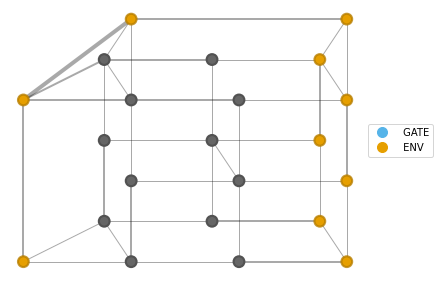

In [70]:
reload(beeky)
psi = beeky.QubitEncodeVector.rand(Lx=3,Ly=3, bond_dim=2)
psi.setup_bmps_contraction_()
norm, bra, ket = psi.make_norm(return_all=True)

# norm.add_tag(tag='GATE', where=('Q4', 'Q7', 'Q10'), which='any')
where = (4,7,10)
nnorm = bra|ket.apply_mpo(mpoham.get_term_at(*where), where, contract=True)


corner = (2,2)
bsz = (3,2)
plaq_envs=norm.compute_plaquette_environments(x_bsz=bsz[0], y_bsz=bsz[1], layer_tags=('BRA','KET'), first_contract='rows')
plaq = norm.plaquette_at(xy=corner, bsz=bsz)
env = plaq_envs[corner, bsz]
env.add_tag('ENV')
(plaq & env).view_as(beeky.QubitEncodeNet, like=norm).graph_layers(color=['GATE','ENV'])

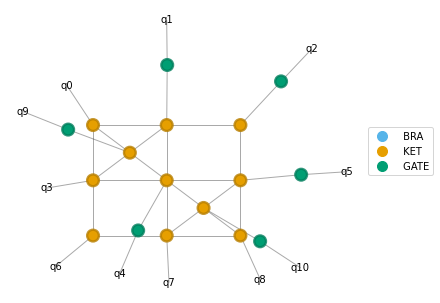

In [64]:
reload(beeky)
qlat = dq.QubitLattice(3,3)
hstab = beeky.HamStab(qlat)
stab_term = list(hstab.gen_ham_stabilizer_lists())[0]

psish = beeky.QubitEncodeVector.rand(Lx=3,Ly=3, bond_dim=2)
for k in range(6):
    qubit = stab_term[0][k]
    gate = stab_term[1][k]
    psish.apply_gate_(G=gate, where=qubit, contract=False)
psish.add_tag('KET')
psish.graph(color=['BRA','KET','GATE'])
# psish.setup_bmps_contraction_()
# norm = psish.make_norm()
# norm.graph_layers(color=['BRA','KET','GATE'])
# norm.graph()

In [23]:
import re
grex = re.compile(r'S\d,\d')
grex.match('S2,4')

<re.Match object; span=(0, 4), match='S2,4'>

In [494]:
reload(beeky)
reload(dq)
# from collections import defaultdict

LX, LY = 3, 3
T_PARAM, V_PARAM, MU_PARAM = (1, 0.2, 0.5)
D_PEPS = 3

qlat = dq.SpinlessHub(Lx=LX, Ly=LY)
mpoHam = beeky.MPOSpinlessHam(qlat, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)
HubHam = beeky.SpinlessSimHam(Lx=LX, Ly=LY, t=T_PARAM, V=V_PARAM, mu=MU_PARAM)

qubit_terms = dict(HubHam.gen_ham_terms())

horizontal_terms = dict(HubHam.gen_horizontal_ham_terms())

vertical_terms = dict(HubHam.gen_vertical_ham_terms())

qvec = beeky.QubitEncodeVector.rand(LX, LY, bond_dim=D_PEPS)

E_exact = qvec.compute_ham_expec(HubHam) 
print(E_exact)
exact_energies[D_PEPS] = E_exact
print(qvec.compute_mpo_ham_expec(mpoHam))

# energies = dict()
# exact_energies = dict()

(-1.902175384196309-1.368237446833082e-17j)
(-1.902175384196309-1.645999936039798e-17j)


In [495]:
qtest = qvec.copy()
qtest.setup_bmps_contraction_()

for chi in range(3, 20):
    
    # if (chi, D_PEPS) not in energies:

    he = qtest.compute_local_expectation(horizontal_terms, normalized=True, max_bond=chi)

    ve = qtest.compute_local_expectation(vertical_terms, normalized=True, max_bond=chi)

    energies[chi, D_PEPS] = he + ve



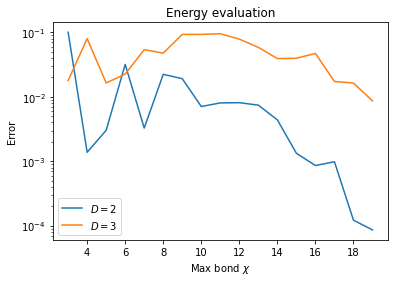

In [498]:
from collections import defaultdict
diffs = defaultdict(list)
chis = defaultdict(list)

for k, v in energies.items():
    D = k[1]
    diffs[D].append(abs(v - exact_energies[D]))
    chis[D].append(k[0])

for d in [2,3]:
    plt.semilogy(chis[d], diffs[d], label=f'$D={d}$')
plt.xlabel(r'Max bond $\chi$')
plt.ylabel(r'Error')
plt.title(r'Energy evaluation')
plt.legend()


In [146]:
print(nflat^all)

bsizes = iter([(3,2), (2, 3)])
verts = iter([(0,0), (2,2)])

norms = dict()
for vcoo, bsz in product(verts, bsizes):
    x_bsz, y_bsz = bsz
    plaq = nflat.plaquette_at(xy=vcoo, x_bsz=x_bsz, y_bsz=y_bsz)
    env = plaq_envs[vcoo, bsz]
    env.add_tag('ENV')
    norms[vcoo, bsz] = (plaq & env).view_as(beeky.QubitEncodeNet, like=nflat)
    # print(norm^all)
    

(-0.19583540643404068+0j)


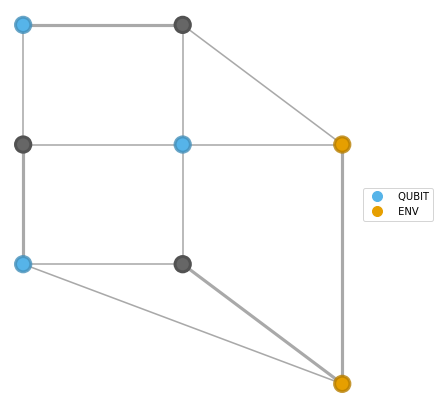

In [151]:
norms[(0,0), (3,2)].graph(color=['QUBIT', 'ENV'])